# Traffic Prediction Dataset

## Описание данных

It is a valuable resource for studying traffic conditions as it contains information collected by a computer vision model. The model detects four classes of vehicles: cars, bikes, buses, and trucks. The dataset is stored in a CSV file and includes additional columns such as time in hours, date, days of the week, and counts for each vehicle type (CarCount, BikeCount, BusCount, TruckCount). The "Total" column represents the total count of all vehicle types detected within a 15-minute duration.

The dataset is updated every 15 minutes, providing a comprehensive view of traffic patterns over the course of one month. Additionally, the dataset includes a column indicating the traffic situation categorized into four classes: 1-Heavy, 2-High, 3-Normal, and 4-Low. This information can help assess the severity of congestion and monitor traffic conditions at different times and days of the week.

The dataset is useful in transportation planning, congestion management, and traffic flow analysis. It helps understand vehicle demand, identify congested areas, and inform infrastructure improvements. The dataset enables targeted interventions like signal optimizations and lane adjustments. It allows researchers to study traffic patterns by hour, day, or specific dates and explore correlations with external factors. It supports transportation research on vehicle relationships and traffic behavior. Urban planners can assess traffic impact for zoning and infrastructure decisions. Overall, the dataset empowers stakeholders to make data-driven decisions, enhance urban mobility, and create efficient and sustainable cities.

## Цель проекта
Разработать модель, способную **прогнозировать транспортный поток** (т.е. количество автомобилей, проезжающих по участку дороги в час) на основе временных и контекстных признаков: времени суток, дня недели, погодных условий и др.

## Ход исследования:

1. Загружу и изучу данные
2. Предобработка (пропуски, дубликаты, аномалии, типы данных)
3. Исследовательский анализ
   - статистический анализ;
   - графики;
   - посмотреть, есть ли вы выбросы, необычное распределение количественных признаков или другие особенности;
   - как улучшить данные? (часы пик, выходные/будни....)
4. Корреляционный анализ
5. Задача регрессии
6. Вывод

Пропущу шаги 3-4, сразу учитывая, что:
- в часы пик интенсивность движения выше;
- есть смысл разделить будние и выходные дни.

## Загрузка данных

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)
import seaborn as sns
import phik
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error

RANDOM_STATE = 42

In [3]:
df = pd.read_csv("C:\\Users\\lazar\\Downloads\\Transport_models\\Traffic.csv")

In [4]:
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


## Предобработка

In [5]:
df.isna().sum()

Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
dtype: int64

Нет пропусков в данных.

In [6]:
df.duplicated().sum()

0

Также нет дубликатов.

Посмотрим общую информацию о данных:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


Необходимо перевести столбец Time в тип datetime. Затем выделить отдельно час и минуты.

In [8]:
# Перевод Time в datetime
df['Time_dt'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p')

# Выделяем час и минуты
df['Hour'] = df['Time_dt'].dt.hour
df['Minute'] = df['Time_dt'].dt.minute
df['Quarter'] = df['Minute'] // 15  # 0 = 0-15 мин, 1 = 15-30 мин, и т.д.


In [9]:
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Time_dt,Hour,Minute,Quarter
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,1900-01-01 00:00:00,0,0,0
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,1900-01-01 00:15:00,0,15,1
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,1900-01-01 00:30:00,0,30,2
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,1900-01-01 00:45:00,0,45,3
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,1900-01-01 01:00:00,1,0,0


In [10]:
df['Time_in_minutes'] = df['Hour'] * 60 + df['Minute']

In [12]:
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Time_dt,Hour,Minute,Quarter,Time_in_minutes
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,1900-01-01 00:00:00,0,0,0,0
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,1900-01-01 00:15:00,0,15,1,15
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,1900-01-01 00:30:00,0,30,2,30
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,1900-01-01 00:45:00,0,45,3,45
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,1900-01-01 01:00:00,1,0,0,60


In [13]:
df.dtypes

Time                         object
Date                          int64
Day of the week              object
CarCount                      int64
BikeCount                     int64
BusCount                      int64
TruckCount                    int64
Total                         int64
Traffic Situation            object
Time_dt              datetime64[ns]
Hour                          int32
Minute                        int32
Quarter                       int32
Time_in_minutes               int32
dtype: object

Далее переведем день недели в числовой формат, чтобы загрузить этот признак в модель:

In [14]:
# День недели в числовой формат
day_mapping = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df['Day_of_week'] = df['Day of the week'].map(day_mapping)


In [15]:
# 1 - выходной, 0 - будний
df['Is_weekend'] = df['Day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


In [16]:
# 1 - если в час пик
def is_peak(hour):
    return 1 if (7 <= hour <= 9) or (17 <= hour <= 19) else 0

df['Is_peak_hour'] = df['Hour'].apply(is_peak)


In [17]:
df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Time_dt,Hour,Minute,Quarter,Time_in_minutes,Day_of_week,Is_weekend,Is_peak_hour
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,1900-01-01 00:00:00,0,0,0,0,1,0,0
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,1900-01-01 00:15:00,0,15,1,15,1,0,0
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,1900-01-01 00:30:00,0,30,2,30,1,0,0
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,1900-01-01 00:45:00,0,45,3,45,1,0,0
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,1900-01-01 01:00:00,1,0,0,60,1,0,0


## Модель линейной регрессии

Добавляем в модель следующие признаки (приведенные к корректному формату):
- время;
- день недели;
- час пик (да/нет);
- дата.

In [27]:
# выделяем в отдельные переменные целевой признак и входные признаки
X = df.drop('Total', axis=1)
y = df['Total']

# разделение данных на тренировочную и тестовую выборки, фиксируем random_state
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = RANDOM_STATE
)

# список категориальных признаков
cat_col_names = ['Hour', 'Minute', 'Quarter', 'Day_of_week', 'Is_weekend', 'Is_peak_hour']

# список количественных признаков
num_col_names = ['Date', 'Time_in_minutes']

# выполняем кодирование категориальных признаков
# переменная с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# обучение и преобразование категориальных признаков тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# преобразование категориальных признаков тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names])

# получаем список новых столбцов
encoder_col_names = encoder.get_feature_names_out()

# выполняем масштабирование количественных признаков
# переменная с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучение и преобразование количественных признаков тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# преобразование количественных признаков тестовой выборки
X_test_scaled = scaler.transform(X_test[num_col_names])

# создаём тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединяем все преобразованные данные в тренировочный и тестовый датафреймы
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train.head()

,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_6,Hour_7,Hour_8,Hour_9,Hour_10,...,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6,Is_weekend_1,Is_peak_hour_1,Date,Time_in_minutes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.339378,-0.337215
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.120925,-1.347746
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,-1.232757,0.817677
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.003882,1.359032
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.227546,-0.337215


In [28]:
# посмотрим размерность выборок, чтобы удостовериться, что разделение данных прошло успешно
print(df.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2976, 17)
(2232, 39)
(744, 39)
(2232,)
(744,)


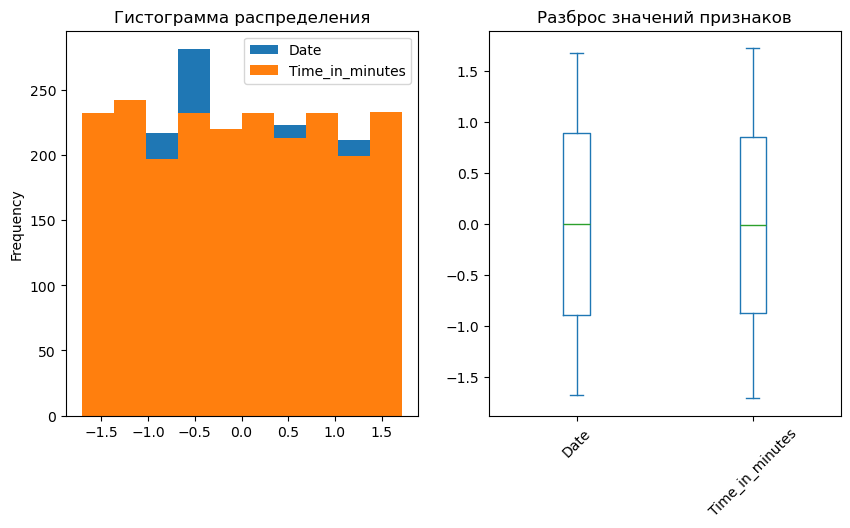

In [29]:
# строим графики по количественным признакам тренировочной выборки
ig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

X_train[num_col_names].plot(kind='hist', bins=10, ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [30]:
# инициализация модели линейной регрессии
model_lr = LinearRegression()

# обучение модели на тренировочных данных
model_lr.fit(X_train, y_train)

# получаем предсказания модели на тестовых данных
predictions = model_lr.predict(X_test)

# рассчет значения R2 для линейной регрессии

r2 = r2_score(y_test, predictions)

print("R2 LinearRegression =", r2)

R2 LinearRegression = 0.6128134744281626


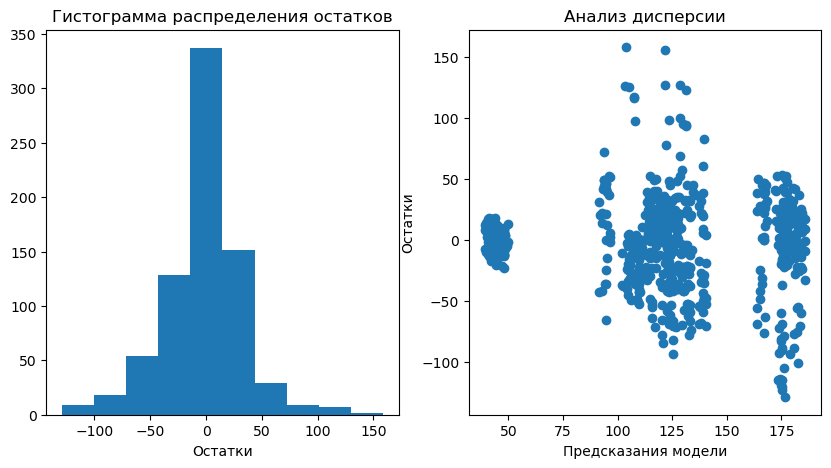

In [31]:
# расчет и анализ остатков
residuals = y_test - predictions

# гистограмма частотности распределения и диаграмма рассеяния
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
plt.show()

In [34]:
mse = mean_squared_error(y_test, predictions)
rmse = root_mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'MSE = {mse}')
print(f'RMSE = {rmse}')
print(f'MAE = {mae}')

MSE = 1309.6133287674318
RMSE = 36.188580087749116
MAE = 25.493013648576635


## Вывод

- Чем ближе к единице значение R², тем точнее предсказывает модель. Модель неплохо обучилась - 61% предсказаний модели ближе к истине, чем среднее значение целевого признака;
- Гистограмма остатков похожа на нормальное распределение;
- Дисперсия остатков не постоянная (меняется для разных диапазонов предсказаний);
- Нужно улучшать модель - добавлять признаки и/или трансформировать данные, чтобы изменить взаимосвязь входных признаков с целевым;
- Метрика RMSE показывает, что модель в среднем ошибается на 37 автомобилей, MAE - на 26.